#**Install**

In [1]:
!git clone https://github.com/facebookresearch/fastText.git
!cd fasttext
!pip install fastText

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 32.77 MiB/s, done.
Resolving deltas: 100% (2418/2418), done.
/bin/bash: line 0: cd: fasttext: No such file or directory
     |████████████████████████████████| 71kB 2.0MB/s 
  Created wheel for fastText: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3018816 sha256=030c5650c3c4d65177e4f55df9f19335afff07c3b267eebb4bc2515ad2494b07
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fastText


# **Data 불러오기**

In [1]:
!wget https://dl.fbaipublicfiles.com/fasttext/data/cooking.stackexchange.tar.gz && tar xvzf cooking.stackexchange.tar.gz

--2020-09-24 00:50:51--  https://dl.fbaipublicfiles.com/fasttext/data/cooking.stackexchange.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 457609 (447K) [application/x-tar]
Saving to: ‘cooking.stackexchange.tar.gz’

cooking.stackexchan 100%[===================>] 446.88K   745KB/s    in 0.6s    

2020-09-24 00:50:52 (745 KB/s) - ‘cooking.stackexchange.tar.gz’ saved [457609/457609]

cooking.stackexchange.id
cooking.stackexchange.txt
readme.txt


In [3]:
# 15404개의 데이터
!wc cooking.stackexchange.txt

  15404  169582 1401900 cooking.stackexchange.txt


In [4]:
# train과 valid 데이터로 split
!head -n 12404 cooking.stackexchange.txt > cooking.train
!tail -n 3000 cooking.stackexchange.txt > cooking.valid

# **Text Classification**
Input file
- utf-8로 인코딩되어 있어야함.
- 각 문장마다 하나 이상의 label이 있어야함




In [5]:
import fasttext

In [6]:
# 모델 학습
model = fasttext.train_supervised(input="cooking.train")

In [7]:
# 학습된 모델 저장,load_model로 불러올 수 있음
model.save_model("model_cooking.bin")

In [8]:
# 예측: label 값 반환
model.predict("Which baking dish is best to bake a banana bread ?")

(('__label__baking',), array([0.07257967]))

In [9]:
model.predict("Why not put knives in the dishwasher?")

(('__label__food-safety',), array([0.07451777]))

In [10]:
# 학습한 모델 valid 데이터에서 실행. sample 수, 정밀도, 재현율 반환
model.test("cooking.valid")

(3000, 0.135, 0.05838258613233386)

In [11]:
 # 상위 5개 label 반환
 model.predict("Why not put knives in the dishwasher?", k=5)

(('__label__food-safety',
  '__label__baking',
  '__label__bread',
  '__label__substitutions',
  '__label__equipment'),
 array([0.07451777, 0.07366108, 0.04390582, 0.0373    , 0.03408055]))

# **전처리 후 학습**

In [12]:
# 데이터 전처리 및 split
!cat cooking.stackexchange.txt | sed -e "s/\([.\!?,'/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > cooking.preprocessed.txt
!head -n 12404 cooking.preprocessed.txt > cooking.train
!tail -n 3000 cooking.preprocessed.txt > cooking.valid

In [13]:
# 모델 학습
model = fasttext.train_supervised(input="cooking.train")

In [14]:
model.test("cooking.valid")

(3000, 0.16433333333333333, 0.07106818509442121)

# **Parameter**

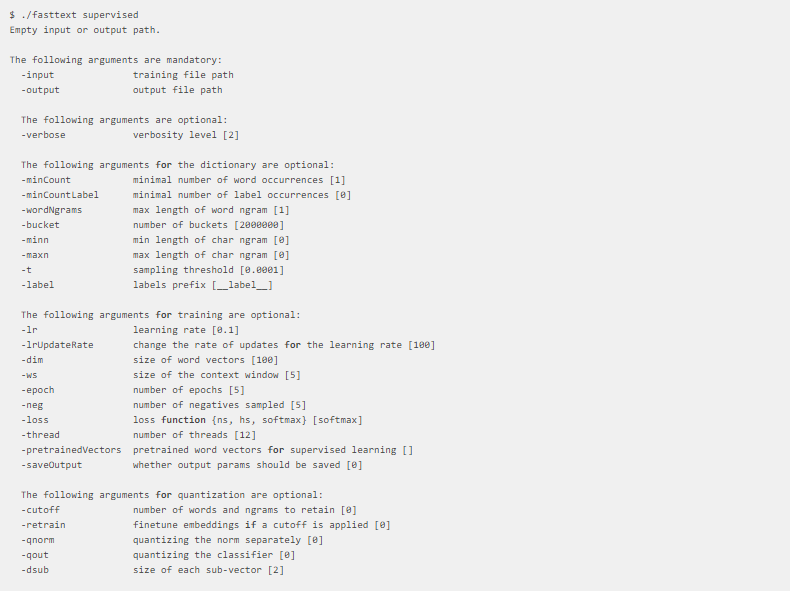



*   epoch 변화 (-epoch, 표준 범위: 5 - 50)
*   learning rate 변화 (- lr, 표준 범위: 0.1 - 1.0)
*   word n-gram 사용 (-wordNgrams, 표준 범위: 1 - 5)




In [15]:
# epoch, learning_rate 증가
model = fasttext.train_supervised(input="cooking.train", epoch=25, lr=1.0)

In [16]:
model.test("cooking.valid")

(3000, 0.5843333333333334, 0.25270289750612657)

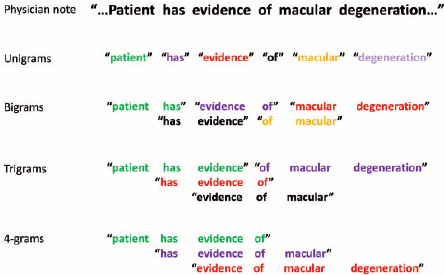

In [17]:
# wordNgram=2(Bigram)
model = fasttext.train_supervised(input="cooking.train", lr=1.0, epoch=25, wordNgrams=2)

In [18]:
model.test('cooking.valid')

(3000, 0.5996666666666667, 0.2593340060544904)

# **Hierarchical Softmax**

기존의 softmax 비용 함수를 대신하여 빠른 계산을 위하여 사용하는 비용 함수.

In [19]:
model = fasttext.train_supervised(input="cooking.train", lr=1.0, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='hs')

In [20]:
model.test('cooking.valid')

(3000, 0.5806666666666667, 0.25111719763586565)

# **Multi-label Classification**
하나의 문장에 여러개의 label 값을 반환.
(loss = 'one-vs-all' 나 loss = 'ova'로 실행할 수 있음)


In [21]:
model = fasttext.train_supervised(input="cooking.train", lr=0.5, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='ova')

model.predict의 파라미터 값
- k=-1을 설정하여 가능한 많은 label 반환
- Threshold 이상의 확률인 label 반환 

In [22]:
model.predict("Which baking dish is best to bake a banana bread ?", k=-1, threshold=0.5)

(('__label__baking',
  '__label__equipment',
  '__label__bread',
  '__label__bananas'),
 array([1.00001001, 0.97967768, 0.97632056, 0.8872146 ]))

In [23]:
model.test("cooking.valid", k=-1)

(3000, 0.003146031746031746, 1.0)